In [1]:
%load_ext imgtex
%load_ext dot
%matplotlib inline

import instrumentation.runtime as rt
import dot
import dot.fsm

FSM = dot.fsm.fsm
FSM2 = lambda r, *a, **kw: FSM(r.m.start, r.m.accepts, r.m.delta, *a, **kw)

# Regular Expressions ~~~#

Not long ago, I responded to a question on building a regular expression to handle a pair of cases, and subsequent discussion briefly referenced the limits of what can and should be done with regexes. In addition to giving me the perfect excuse to trot out perhaps the most famous [Stackoverflow answer of all time](https://stackoverflow.com/questions/1732348/regex-match-open-tags-except-xhtml-self-contained-tags/1732454#1732454), it also brought my mind back to the post I did earlier this year, wherein I began the solution of a math problem with a regular expression. Given those things, and the fact that we as programmers often use and misuse regexes to great effect, it pays to take a closer look at what they are, what they can and cannot represent, and why.

## Example 1: IPv4 Addresses

An IP4 address is typically written in dotted quad notation, e.g., 192.168.0.1. It's a fairly common occurrence that we might need to break them out of otherwise unstructured text, and the typical tool for the job is a regular expression. For example, if we only focus on the basic idea of three digit groupings separated by periods, without worrying about whether we actually have a valid IP address, we might try:

```
/[0-9]+\.[0-9]+\.[0-9]+\.[0-9]+/
```

Depending on the flavor of regex syntax available, we might even lean on built-in character classes to shorten the expression; however, syntactic sugar is entirely beside the point today. Instead, I want to focus on a different question: When you pound that regex into `re.compile`, or `grep`, or anything else, what happens? Today, we'll ignore what `grep`, etc., actually do (i.e., their implementations) and instead consider the fundamental theory atop which they're built.

## Welcome to the (Finite State) Machine

Suppose the Python regular expression library did not exist, and suppose you had to write a function to test whether a given string is an IP address. How would you do it? Most likely, you'd start by scanning the string one character at a time, keeping track of how many dots you've encountered and whether the most recent character was a digit, as well as immediately failing on any character that doesn't belong in an IP address. A possible implementation might look like:

In [2]:
def is_ip(s):
    dots = 0
    read_digits = False
    for c in s:
        if read_digits and c == '.':
            dots += 1
            read_digits = False
            if dots > 3: return False
        elif c.isdigit(): read_digits = True
        else: return False
    return dots == 3 and read_digits

With only a smattering of cleverness, this works. All we had to do was track a couple bits of state and, depending on the current state and the character we're processing, decide how to change the state in response, immediately failing when we observe anything out of place in an IP address. Denoting the state by pairs `(dots, read_digits)`, we can explicate the state transitions as follows:

| State    | 0-9     | .
| :---     | :---    | :---
| 0, False | 0, True | fail
| 0, True  | 0, True | 1, False
| 1, False | 1, True | fail    
| 1, True  | 1, True | 2, False
| 2, False | 2, True | fail
| 2, True  | 2, True | 3, False
| 3, False | 3, True | fail
| 3, True  | 3, True | fail

Or, for the graphically inclined, and omitting the transitions to the failure state:

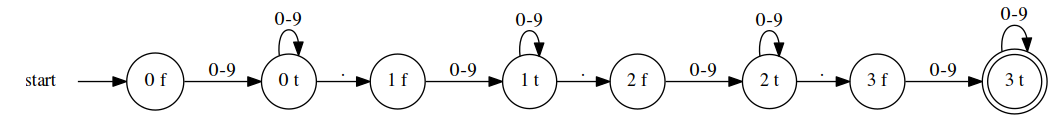

In [3]:
FSM(
        "0 f",
        ["3 t"],
        {
            '0 f': {'0-9': '0 t'},
            '0 t': {'0-9': '0 t', '.': '1 f'},
            '1 f': {'0-9': '1 t'},
            '1 t': {'0-9': '1 t', '.': '2 f'},
            '2 f': {'0-9': '2 t'},
            '2 t': {'0-9': '2 t', '.': '3 f'},
            '3 f': {'0-9': '3 t'},
            '3 f': {'0-9': '3 t'},
            '3 t': {'0-9': '3 t'}
        }
    )


What we now have are two different representations of a finite state machine; more specifically, since our state machine features at most one transition from any given state on a given input (i.e., the transition for a given state on a given input is _uniquely determined_), it is a deterministic finite automaton (DFA). It is no accident that we began with a regular expression and reasoned our way to a DFA, for it is a fundamental result in the theory of computation that regular expressions and DFAs are equivalent.

Since DFAs are useful conceptual tools, let's come up with a way to express them in code succinctly. In much more formal discussions of DFAs, they're specified by the tuples

In [4]:
%%latex
$$ \left(Q, q_0, F, \Sigma, \delta\right) $$

where _Q_ is a set of states; _q<sub>0</sub> _&in; _Q_ is the starting  state; _F_ &sube; _Q_ is the set of _accepting_ states; &Sigma; is the set of valid input symbols; and &delta; is the transition function, mapping initial state/input symbol pairs to next states (or, to be more mathematical, &delta;: _Q_ &times; &Sigma; &rightarrow; _Q_).

While we certainly need to be careful in how we specify DFAs in code, we can, as a practical matter, trim back what needs to be explicitly specified. For example, we can infer both &Sigma; and _Q_ from &delta; whenever we need them. We can also omit from &delta; any transitions that would place the DFA into a failing state with no hope of recovery (also called a _trap state_). With these things in mind,

In [5]:
class dfa:
    def __init__(self, start, accepts, delta):
        '''
        Initialize a new DFA.
        q_0 -> start
        F -> accepts
        transition function -> delta
        '''
        self.start = start
        self.accepts = set(accepts)
        self.delta = delta
    
    def step(self, state, x):
        ''' 
        Evaluate the state transition function, self.delta, for  (state, x).
        '''
        return self.delta[state][x]
    
    def __call__(self, xs):
        '''
        Starting in state self.start, determine whether input  sequence xs will 
        place the DFA in an accepting state.
        '''
        state = self.start
        for x in xs:
            try: state = self.step(state, x)
            except KeyError: return False
        return state in self.accepts

Next, we'll create a couple utilities to stand in for character classes:

In [6]:
# the idea here is to generate sequences of (symbol, next_state) pairs that can 
# then be composed, converted to dictionaries, and grafted into a delta 
# specification

def charclass(cs_): 
    cs = set(cs_)
    return lambda to: [(c, to) for c in cs]

digits = charclass(str(i) for i in range(10))
dot_ = lambda to: [('.', to)]

And now, we can specify a DFA that recognizes IP addresses, like so:

In [7]:
is_ip = dfa(
    "0 f",
    ["3 t"],
    {
        '0 f': dict(digits('0 t')),
        '0 t': dict(digits('0 t') + dot_('1 f')),
        '1 f': dict(digits('1 t')),
        '1 t': dict(digits('1 t') + dot_('2 f')),
        '2 f': dict(digits('2 t')),
        '2 t': dict(digits('2 t') + dot_('3 f')),
        '3 f': dict(digits('3 t')),
        '3 t': dict(digits('3 t'))
    }
)

Which responds as expected to various test inputs:

In [8]:
for s in ('127.0.0.1', 
          '1.2.3', 
          '255.255.256.255', # invalid, but still fits our pattern
          '10.0.zero.1'): 
    print("%-16s" % s, is_ip(s))

127.0.0.1        True
1.2.3            False
255.255.256.255  True
10.0.zero.1      False


Keep in mind that our search pattern is technically underspecified, which is why our DFA is saying that 255.255.256.255 is a valid address. We know it isn't, but we don't yet have good tools for creating a state machine that does the right thing. Until we do, let's shift gears to a different problem.

## Example 2: Losing Prize Strings

In an earlier post I began the solution to a problem, counting winning prize strings, by expressing its complement, i.e., describing all losing prize strings. The regular expression I used (over an input alphabet of {O, L, A}) was

```
/^.*AAA.*$|^.*L.*L.*$/
```

and the DFA that I crafted based on it was

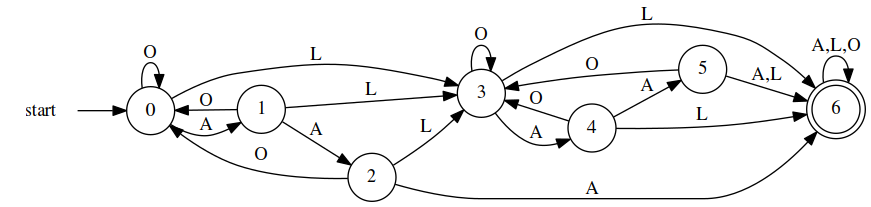

In [9]:
FSM(
    0,
    [6],
    {
        0: {'O': 0, 'A': 1, 'L': 3},
        1: {'O': 0, 'A': 2, 'L': 3},
        2: {'O': 0, 'A': 6, 'L': 3},
        3: {'O': 3, 'A': 4, 'L': 6},
        4: {'O': 3, 'A': 5, 'L': 6},
        5: {'O': 3, 'A': 6, 'L': 6},
        6: {'O': 6, 'A': 6, 'L': 6}        
    }
)

The reasoning behind this DFA is pretty simple:

* A losing sequence will contain:
  * at least two late arrivals (L); or,
  * three consecutive absences (A).
* Given the rule of lateness, I was able to partition the machine into two major stages, with state transitioning from the first major stage to the second on encountering the first 'L', and from the second to the accepting state (i.e, losing) on the second 'L'.

* Given the rule of absences, in each major stage, I had to keep watch for three consecutive 'A's, transitioning straight to the accepting state whenever that condition was met.

This artisanal DFA allowed me to do what I needed to do, but, had the rules of the game been more complicated, requiring a more complicated regex, crafting the transition function myself would hardly have been a picnic. Luckily, we have these fantastic devices that do precisely as they're told. 

Unfortunately, a process requiring even a little cleverness is hardly suitable for automation, and designing with DFAs requires entirely too much cleverness: To manually construct a DFA that can handle multiple choices, as the above does, we have to figure out how to accomodate a superposition of possibilities until we have enough information to make a decision. Depending on the regular expression, we can easily require a huge number of states fitted together in ways that aren't necessarily obvious. As a way out of this madness, we can add some design tools:

* We'll relax the requirement that each state transition be uniquely determined. Instead, we'll allow the machine to exist in set of states, and, for each input symbol/initial state pairing, we'll allow a set of possible next states; and,
* We'll allow transitions between states triggered by an imaginary symbol called &epsilon;, which represents an empty string. We'll use this as a method for changing the behavior of a state machine (e.g., adding repetition) or combining state machines merely by adding dummy states and &epsilon;-transitions. (Some texts on this subject use &lambda;, but we're working in Python, and `lambda` is a Python keyword.)

Either one of these is sufficient to introduce nondeterminism to our state machines, resulting in nondeterministic finite automata (NFAs), which are a bit easier to create and compose mechanically. We can instantiate and interpret NFAs in a manner similar to DFAs:

In [10]:
def epsilon_closure(state, delta):
    '''
    From an initial state, identify all states reachable by epsilon  transitions 
    alone.
    '''
    old, new = 0, len(state)
    visited = set()
    while new > old:
        for substate in set(state):
            if substate in visited: continue
            visited.add(substate)
            state |= delta.get(substate, {}).get(None, set())
        old, new = new, len(state)

    return state

class nfa:
    def __init__(self, start, accepts, delta):
        self.start = start
        self.accepts = set(accepts)
        self.delta = delta
    
    def step(self, state, x):
        state_ = set()
        for substate in epsilon_closure(state, self.delta):
            state_ |= set(self.delta.get(substate, {}).get(x, set()))
        return epsilon_closure(state_, self.delta)
    
    def __call__(self, xs):
        state = epsilon_closure(set((self.start,)), self.delta)
        for x in xs: state = self.step(state, x)
        return state & self.accepts > set()

Note that the `delta` is evaluated over a set of possibilities, resulting in a new set of possibilities. Note also the calls to `epsilon_closure`, which iteratively evaluates all of the &epsilon; transitions from a given state.

With the flexibility of nondeterminism, we can think about how to systematically compose automata for various patterns into automata for larger patterns. Suppose we have the expression `/a/`; the NFA for it looks like:

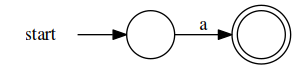

In [11]:
FSM('q_121_0', {'q_121_1'}, {'q_121_0': {'a': {'q_121_1'}}}, nfa=True, label_states=False)

The NFA for `/b/` would look much alike. Now, let's think about `/ab/`. We'll start with NFAs for the individual components:

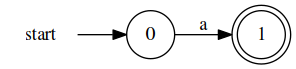

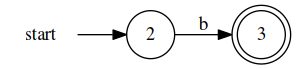

In [12]:
FSM(0, [1], {0: {'a': 1}})
FSM(2, [3], {2: {'b': 3}})

Next, we'll introduce new start and accept states:

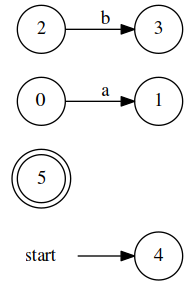

In [13]:
FSM(4, [5], {0: {'a': 1}, 2: {'b': 3}}, trim_unreachable=False) 

Tying those new states into the existing NFAs with &epsilon;-transitions, we get:

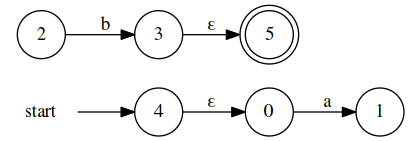

In [14]:
FSM(4, [5], {0: {'a': 1}, 2: {'b': 3}, 4: {None: 0}, 3: {None: 5}}, trim_unreachable=False) 

Finally, connecting the components with an &epsilon;-transition gives the finished result:

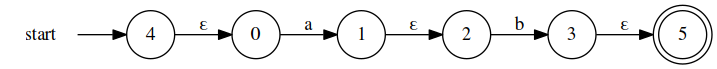

In [15]:
FSM(4, [5], {0: {'a': 1}, 1: {None: 2}, 2: {'b': 3}, 4: {None: 0}, 3: {None: 5}}, trim_unreachable=False) 

We can work in a similar manner for `/a|b/`:

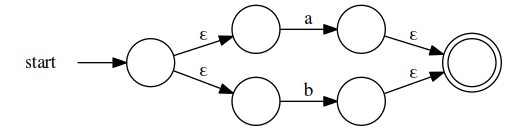

In [16]:
FSM('q_127_0', {'q_127_1'}, {'q_125_0': {'a': {'q_125_1'}}, 'q_126_0': {'b': {'q_126_1'}}, 'q_127_0': {None: {'q_125_0', 'q_126_0'}}, 'q_125_1': {None: {'q_127_1'}}, 'q_126_1': {None: {'q_127_1'}}}, nfa=True, label_states=False)

And for `/a*/`:

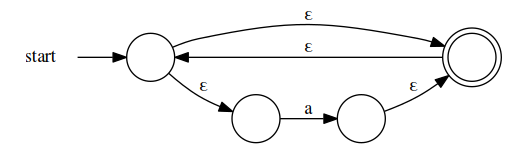

In [17]:
FSM('q_129_0', {'q_129_1'}, {'q_128_0': {'a': {'q_128_1'}}, 'q_129_0': {None: {'q_129_1', 'q_128_0'}}, 'q_128_1': {None: {'q_129_1'}}, 'q_129_1': {None: {'q_129_0'}}}, nfa=True, label_states=False)

Accomodating `/a+/` isn't necessary, since we can get there with `/aa*/`, but it's convenient to have and easy to do:

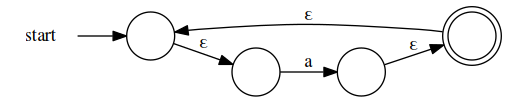

In [18]:
FSM('q_131_0', {'q_131_1'}, {'q_130_0': {'a': {'q_130_1'}}, 'q_131_0': {None: {'q_130_0'}}, 'q_130_1': {None: {'q_131_1'}}, 'q_131_1': {None: {'q_131_0'}}}, nfa=True, label_states=False)

Based on these transformations, let's craft some tools to manage creating and composing NFAs. First, we'll need to add some utilities to `nfa` to keep us from directly manipulating the dictionary that implements its `delta`:

In [19]:
# This trick of a class apparently inheriting from itself allows us to 
# effectively build up a class incrementally over a series of code blocks without
# repeating definitions or explicitly setting class attributes. In truth nfa 
# doesn't inherit from itself, but from the previous version of itself; we don't
# get the same class, but a new class with additional methods. This sort of 
# thing is a good little hack to support literate programming in a notebook, but 
# probably a distraction in an article.

class nfa(nfa):
    def add_transition(self, src, sym, *dests):
        for dest in dests:
            self.delta.setdefault(src, {}).setdefault(sym, set()).add(dest)
            
    def add_delta(self, other):
        delta = other.delta
        for src in delta:
            for sym in delta[src]: 
                self.add_transition(src, sym, *delta[src][sym])
        return self

Now we can construct a wrapper to actually do the NFA composition. For writing regexes as Python expressions, we'll change the regex notation just a little bit, in the following ways:

* For concatenation, we'll overload multiplication. Thus, `/ab/` will be written as `a * b`.
* Rather than use the pipe character (`|`) to represent alternatives, we'll use the plus sign (`+`); so, `/a|b/` will be written as `a + b`.
* For &epsilon;-transitions, we'll use `None` as our input symbol.
* We'll provide methods `plus` and `star` for their respective operations.

And Python gives us parenthesized expressions for free. By the way, I selected these changes of notation for two reasons:

* I had to make a decision about how to co-opt Python's operators to represent regex concatenation, since implying concatenation by juxtaposition only works for string literals; and, 
* Using `*` and `+` for concatenation and alternation, respectively, puts us closer to the notation used in most formal treatments of regular expressions, finite automata, and regular languages.

The wrapper code is as follows:

In [20]:
## why Python provides sum but not product is a great mystery
def product(xs, start=1):
    '''Return the product of a sequence of items and `start`.'''
    for x in xs: start *= x
    return start

class RE:
    '''
    Wrapper for NFAs, allowing us to combine NFAs recognizing simple regexes 
    into NFAs recognizing more complex regexes.
    '''
    
    # Each machine gets a unique identifier on creation, which is used for 
    # naming nodes.This tactic simplifies adding transitions from other 
    # machines.
    
    RE_id = 0 # next machine id
    def node(self, i): return 'q_%s_%s' % (self.id, i)
    
    def __init__(self, c=None):
        '''Create a NFA recognizing a single item /c/.'''
        self.id = RE.RE_id
        RE.RE_id += 1
    
        self.c = c
        self.start = self.node(0)
        self.accept = self.node(1)
        self.m = nfa(self.start, [self.accept], {})
        
        if c == None: self.m.delta = {}
        else:
            self.m.add_transition(self.start,
                                 None if c == '' else c,
                                 self.accept)
    
    def from_string(s):
        '''Create a NFA matching a sequence of items /s/.'''
        return product(map(RE, s), RE(''))
    
    def from_alts(xs):
        '''Create a NFA matching any of a set of items.'''
        return sum(map(RE, xs[1:]), RE(xs[0]))
    
    def __call__(self, xs): 
        '''Run the underlying NFA on the sequence `xs`.'''
        return self.m(xs)
    
    def with_deltas(self, other):
        '''
        new.m.step(q0, s) = self.m.step(q0, s) | other.m.step(q0, s)
        '''
        new = self.__class__()
        new.m.add_delta(self.m)
        new.m.add_delta(other.m)
        return new
    
    def __mul__(self, other):
        '''Concatenate self and other: /ab/'''
        new = self.with_deltas(other)
        new.m.add_transition(new.start,    None, self.start)
        new.m.add_transition(self.accept,  None, other.start)
        new.m.add_transition(other.accept, None, new.accept)
        return new
    
    def __add__(self, other):
        '''Alternation: /a|b/'''
        new = self.with_deltas(other)
        new.m.add_transition(new.start,    None, self.start, other.start)
        new.m.add_transition(self.accept,  None, new.accept)
        new.m.add_transition(other.accept, None, new.accept)
        return new
    
    def star(self):
        '''Kleene star: /a*/'''
        new = self.plus()
        new.m.add_transition(new.start, None, new.accept)
        return new
    
    def plus(self):
        '''At least one: /a+/'''
        new = self.with_deltas(self)
        new.m.add_transition(new.start,   None, self.start)
        new.m.add_transition(self.accept, None, new.accept)
        new.m.add_transition(new.accept,  None, new.start)
        return new

Returning to the example of losing prize strings, let's first define a few conveniences:

In [21]:
ola = lambda: RE.from_alts('OLA')
a = lambda: RE('A')
l = lambda: RE('L')

Now we can express the two major ways to lose:

In [22]:
aaa = ola().star() * a() * a() * a() * ola().star()

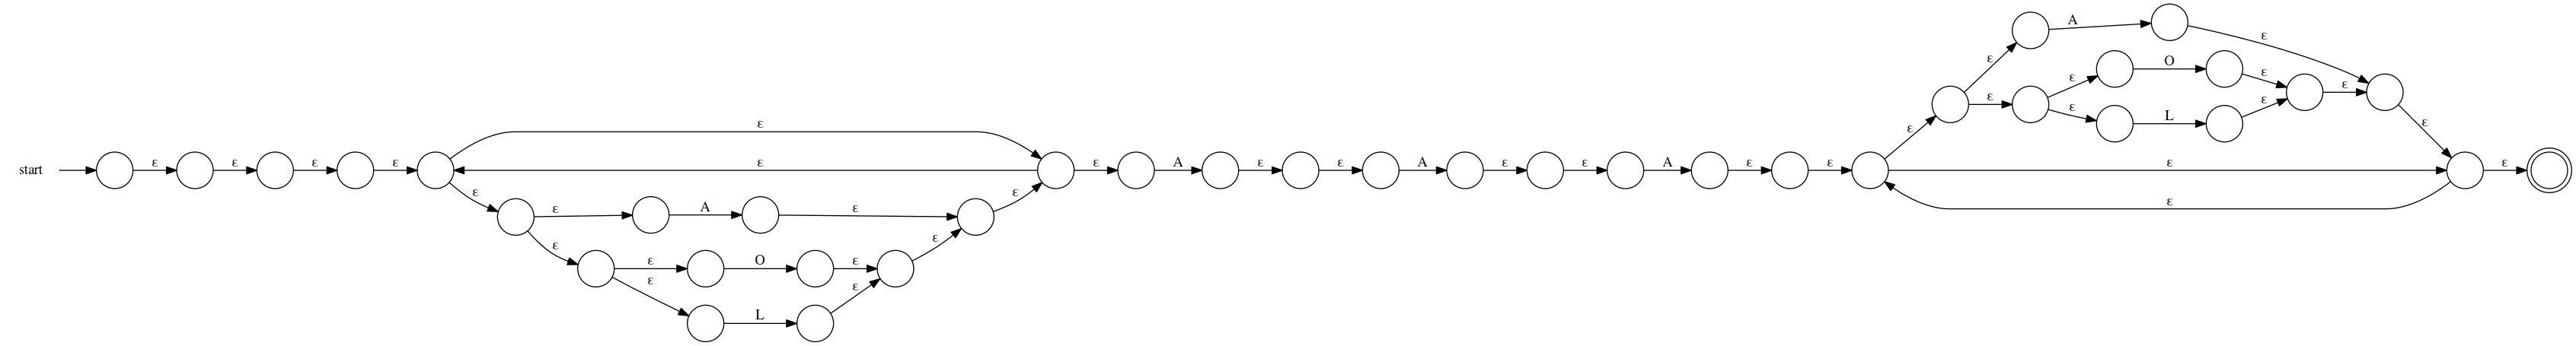

In [23]:
FSM2(aaa, nfa=True, label_states=False)

In [24]:
ll = ola().star() * l() * ola().star() * l() * ola().star()

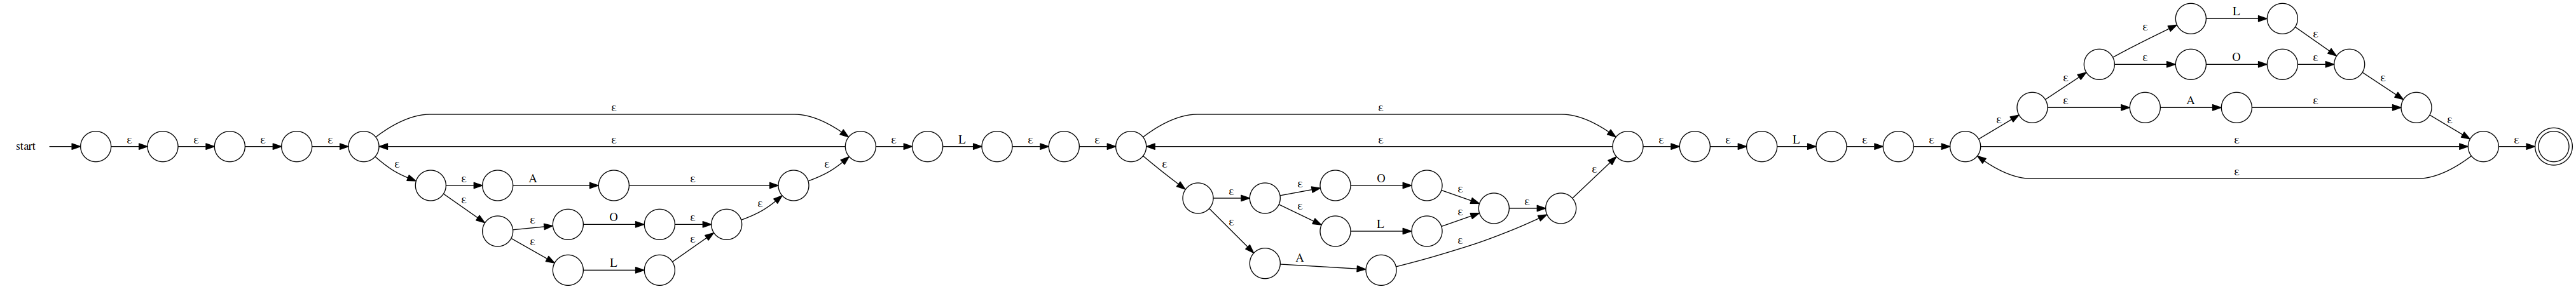

In [25]:
FSM2(ll, nfa=True, label_states=False)

Putting them together, we have,

In [26]:
loss = aaa + ll

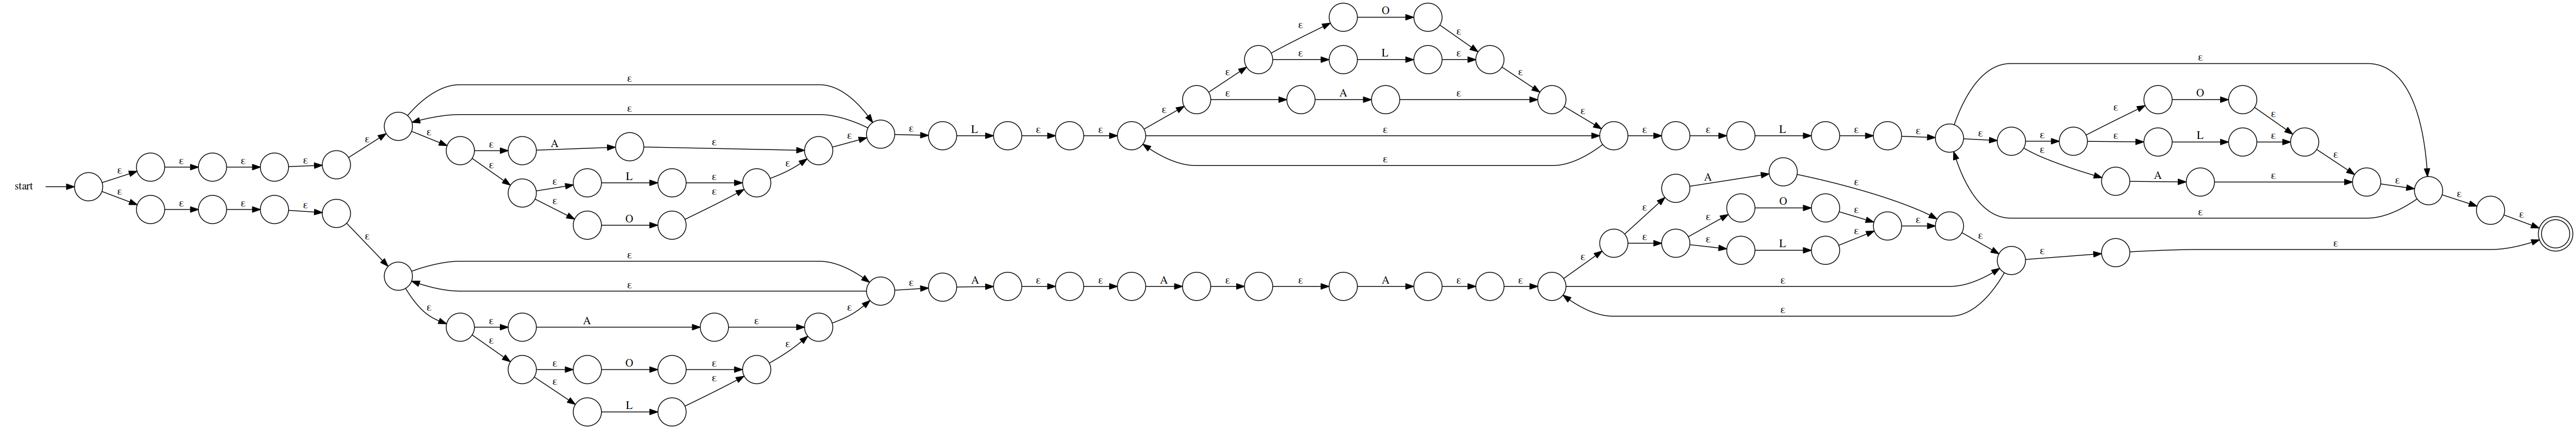

In [27]:
FSM2(loss, nfa=True, label_states=False)

Which, of course, looks nothing at all like the artisanal DFA from before. Even though it looks quite different, though, it does recognize precisely the same set of strings, i.e., the set of all strings resulting in a loss according to the rules of the contest. To prove it, though, we'll have to clear a couple of hurdles.

## Converting NFAs to DFAs

Though there's quite a difference in both the appearance and interpretation of DFAs and NFAs, are they fundamentally different? More to the point, is there anything an NFA can do that some DFA cannot? It turns out that the answer is no, and the reason is hinted at in the NFA `__call__` method, in the use of the terms _state_ and _substate_. The `delta` is not regarded as a state transition function, but rather as a substate transition function; the NFA state is actually a set of substates, each varying independently from the others according to `delta` and the input. Whenever one of the substates is among the `accepts`, the entire NFA is regarded to be in an accepting state. From this interpretation, we can arrive at a couple of conclusions:

* Because the number of substates is finite, the number of states is also finite (it's bounded by the magnitude of the powerset of substates); and,
* Because the state response to an input is the union of the substate responses (&epsilon;-closures included), we can show that there will be one overall state transition for each input and initial state pairing&mdash;i.e., the overall state transition for each input is uniquely determined.

From these, it isn't hard to see that the NFA is really nothing more than a highly compressed representation of a (potentially much larger) DFA. Given that, there must exist at least one DFA for any given NFA, which means that there can be no fundamental difference in power between NFAs and DFAs as computational models. Now to put this into practice.

The algorithm for converting an NFA to a DFA is based on that of finding the transitive closure of a graph from a particular node. In this case, the initial node is a starting state _q<sub>0</sub>_, the edges are state transitions, and the other nodes are the reachable states.

In [28]:
class names():
    '''Provide a convenient way to rename things to integer identifiers.'''
    def __init__(self): self.name = {}
    def __getitem__(self, x): return self.name.setdefault(x, len(self.name))

tuple2 = lambda xs: tuple(sorted(set(xs))) # leave nothing to chance
entuple = lambda x: tuple((x,))

def nfa_to_dfa(N):
    # compute the alphabet of the language that N recognizes from its delta
    sigma = set(sum((list(vs) for vs in N.delta.values()), []))
    sigma.remove(None)
    
    # the renamer; not entirely necessary, but it's nice to keep state names small
    name = names()
    
    # initialize the queue, define a couple conveniences to keep the logic clear
    q0 = entuple(N.start)
    queue = [q0]
    enqueue = queue.append
    dequeue = lambda: queue.pop(0)
    
    visited = set()
    
    # we'll build these as we go
    delta = {}
    accepts = set()
  
    while queue:
        q = dequeue()
        if q in visited: continue
        visited.add(q)
        
        # q is accepting if any of its substates is accepting
        if set(q) & N.accepts: accepts.add(name[q])
            
        for symbol in sigma:
            q_next = tuple2(N.step(set(q), symbol))
            enqueue(tuple2(q_next))
            delta.setdefault(name[q], {})[symbol] = name[q_next]
    
    return dfa(name[q0], accepts, delta)
    

Turning this on the NFA for recognizing losers, we get:

In [29]:
loss_d = nfa_to_dfa(loss.m)

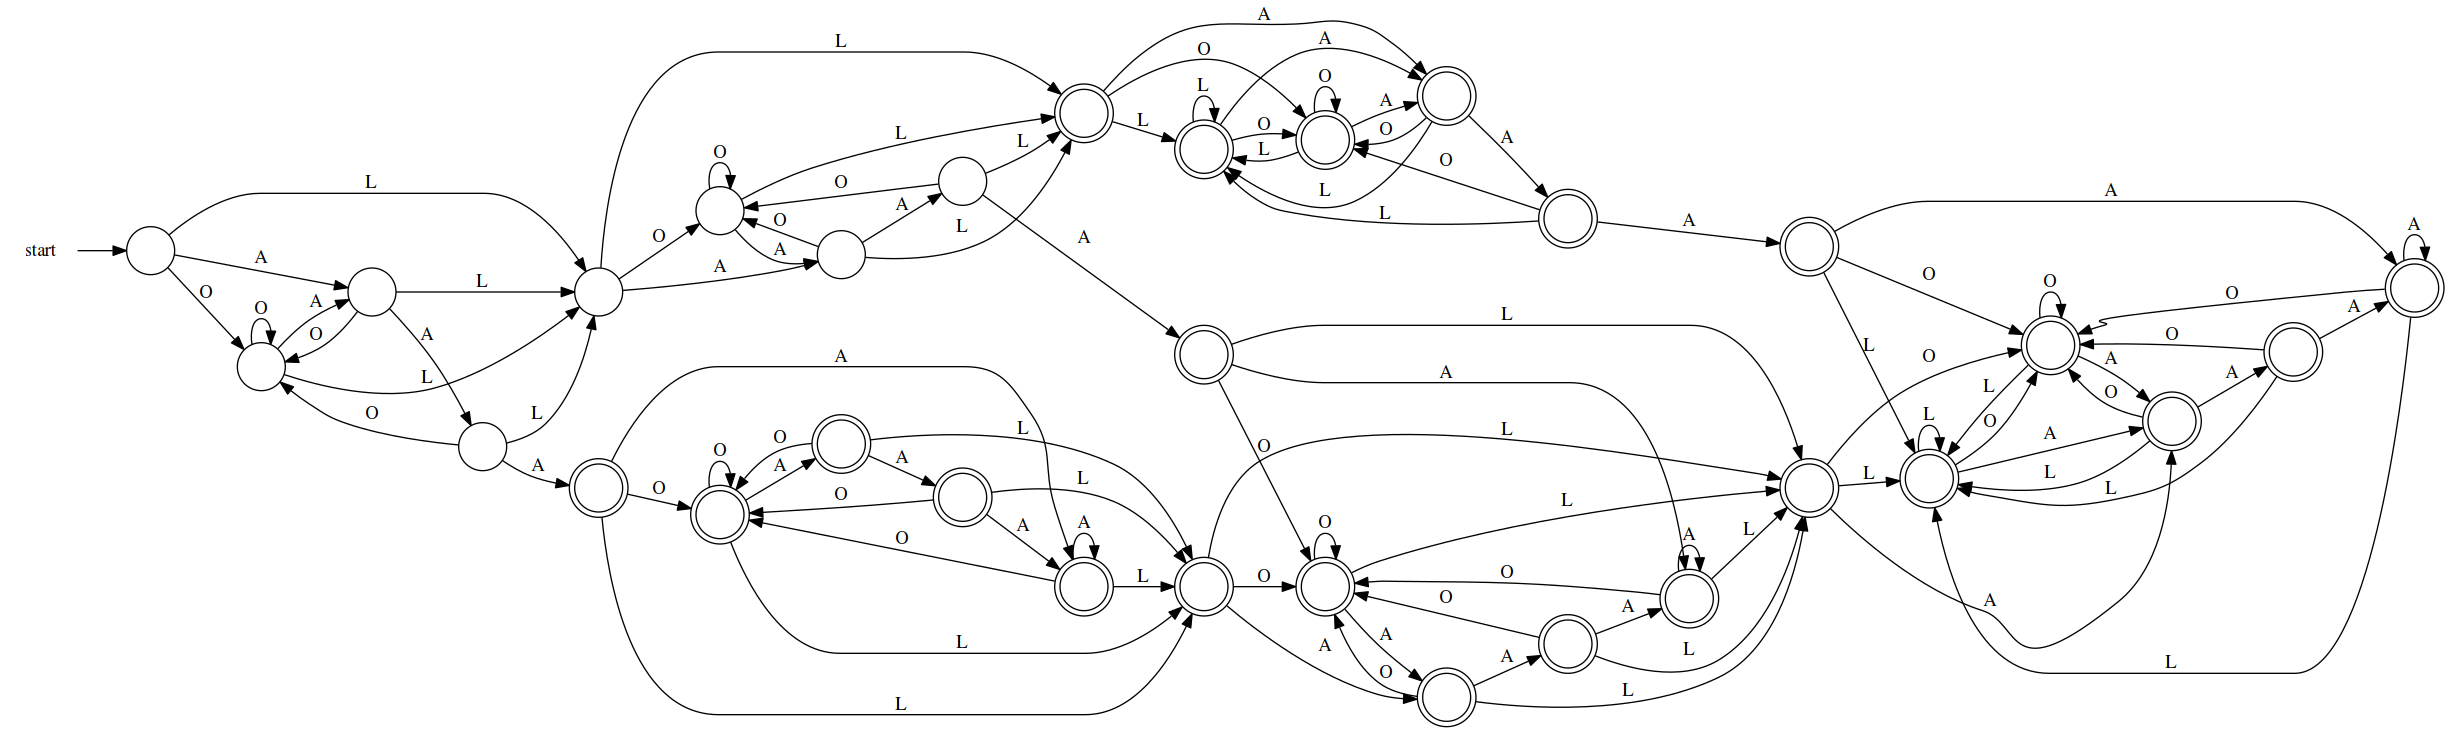

In [30]:
FSM(loss_d.start, loss_d.accepts, loss_d.delta, label_states=False)

This still looks quite different from the original DFA that I produced, but, if you squint, you can begin to make out some high-level commonalities, right up to the profusion of accepting states. Is it possible that there are redundancies in this DFA? What if we could remove them? Automatically?

## DFA Minimization

The key to minimizing a DFA is the idea of indistinguishable states. Suppose we start at state _q_, and we apply every possible sequence of inputs; for each input, we would land in either an accepting or non-accepting state. Let's call this association between input sequences and acceptance the subsequent response for state _q_. Suppose we do this also for state _p_. If the subsequent responses for states _p_ and _q_ are the same, then they are indistinguishable from one another; likewise, if they differ at all, even for the empty string &epsilon; (i.e., one is accepting and the other isn't), then they are distinguishable. Using this idea, we can partition the states of a DFA into _equivalence classes_, where each state in a given equivalence class is indistinguishable from the others. That done, we can merge all the states in each class, with each transition to a constituent state being replaced by a transition to the new merged state.

In [31]:
from itertools import combinations

def pairs(xs): return combinations(xs, 2)

class guarded_memoize:
    '''
    Memoize a function, initializing each new entry with a guard value before 
    calling the function f; this tactic avoids infinite recursion.
    '''
    def __init__(self, f, guard=False):
        self.f = f
        self.cache = {}
        self.guard = guard
        
    def __call__(self, *a, **kw):
        key = '%s %s' % (a, kw)
        if key not in self.cache:
            self.cache[key] = self.guard
            self.cache[key] = self.f(*a, **kw)
        return self.cache[key]

@guarded_memoize
def dist(p, q, m):
    '''Determine whether two states p and q are distinguishable.'''
    
    # two states are distinguishable if one is accepting and the other isn't
    if (p in m.accepts) != (q in m.accepts): return True
    
    # or if there is a sequence of inputs that leads them to distinguishable
    # states
    sigma = set(m.delta[p]) | set(m.delta[q])
    return any(dist(m.delta[p][s], m.delta[q][s], m) for s in sigma)

def equivs(m):
    '''
    Compute a renaming of states in m such that equivalent states will be 
    renamed equivalently.
    '''
    states = set(m.delta)
    for q in m.delta: states |= set(m.delta[q].values())
    indis = {(p,q) for (p,q) in pairs(states) if not dist(p,q,m)}
    acc = {q:set((q,)) for q in states}
    for (p,q) in indis:
        acc[p].add(q)
        acc[q].add(p)
    return {q: '_'.join(map(str, r)) for (q,r) in acc.items()}

def dfa_min(m):
    '''Minimize a DFA.'''
    eq = equivs(m)
    rename = lambda q: eq[q]
    delta = {rename(q): {s:rename(m.delta[q][s]) for s in m.delta[q]} 
             for q in m.delta}
    return dfa(rename(m.start), set(map(rename, m.accepts)), delta)

Applying this minimization technique to `loss_d`,

In [32]:
loss_d_min = dfa_min(loss_d)

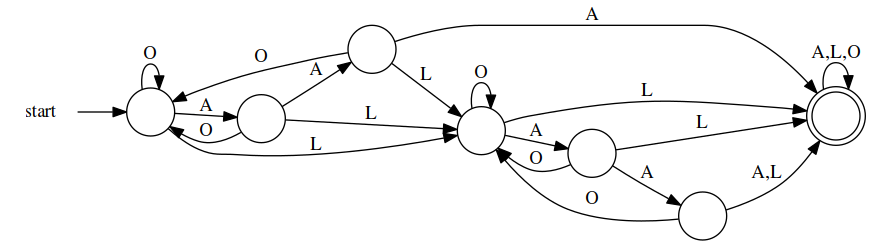

In [33]:
FSM(loss_d_min.start, loss_d_min.accepts, loss_d_min.delta, label_states=False)

## Example 1: IPv4 Addresses&mdash;Revisited

With these tools in hand, we can begin describing IP addresses in a systematic, declarative fashion:

In [34]:
# 0 to 9
digit = lambda: RE.from_alts('0123456789')

# any run of digits
digits = lambda: digit().plus()

# period
per = lambda: RE('.')

# IPv4 address
is_ip = digits() * per() * digits() * per() * digits() * per() * digits()

And the underlying NFA looks like:

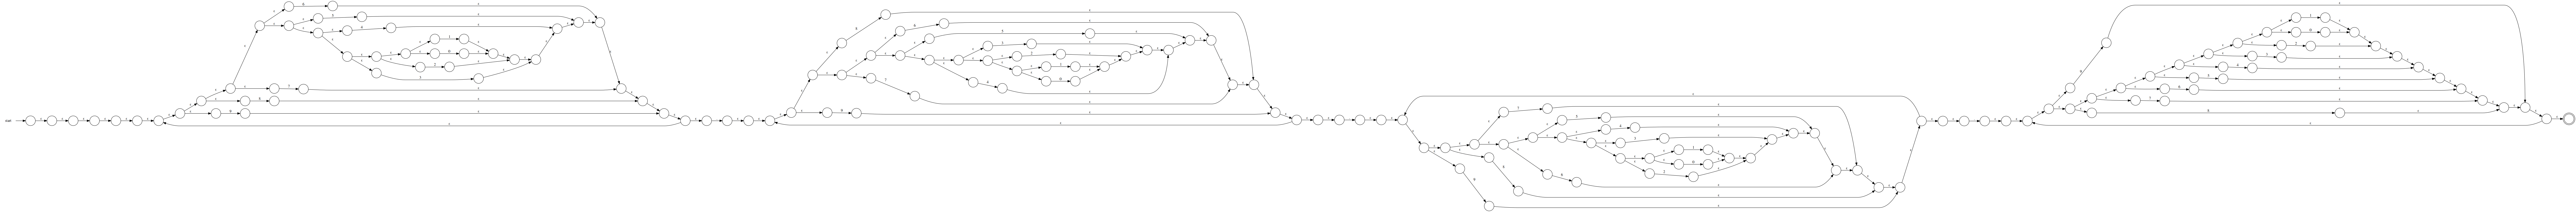

In [35]:
FSM2(is_ip, nfa=True, label_states=False)

Our new state machine performs exactly as the hand-rolled DFA from before:

In [36]:
for s in ('127.0.0.1', 
          '1.2.3', 
          '255.255.256.255', # invalid, but still fits our pattern
          '10.0.zero.1'): 
    print("%-16s" % s, is_ip(s))

127.0.0.1        True
1.2.3            False
255.255.256.255  True
10.0.zero.1      False


because of the way in which we failed to constrain each quad's value. Recall that each part of an IP address has to be in the range 0 to 255 inclusive; instead, we're matching any sequence of digits. The way out of this is to break down the range of valid values into one, two, and three digit numbers, with optional leading zeroes; and to divide the three digit groupings into those from 100 to 199, from 200 to 249, and from 250 to 255. With that partitioning in  mind,

In [37]:
# one and two digits
d1 = digit
d2 = lambda: digit() * digit()

# 100 to 199
d3_1xx = lambda: RE('1') * d2() 

# 200 to 249
d3_200_249 = lambda: RE('2') * RE.from_alts('01234') * digit()

# 250 to 255
d3_250_255 = lambda: RE.from_string('25') * RE.from_alts('012345')

# three digits, 100 to 255
d3 = lambda: d3_1xx() + d3_200_249() + d3_250_255()

# 0 to 255, with any number of leading zeroes
digits = lambda: RE('0').star() * (d1() + d2() + d3())

# IPv4 address
is_ip = digits() * per() * digits() * per() * digits() * per() * digits()

This results in the rather large, well-organized NFA:

In [38]:
FSM2(is_ip, nfa=True, label_states=False)

that performs precisely as we require:

In [39]:
for s in ('127.0.0.1', 
          '1.2.3', 
          '255.255.256.255', # we now fail on this, as we should
          '10.0.zero.1'): 
    print("%-16s" % s, is_ip(s))

127.0.0.1        True
1.2.3            False
255.255.256.255  False
10.0.zero.1      False


The size of the NFA owes largely to the multitude of states having only &epsilon;-transitions created by `RE` as it's operators did their work. Converting it to DFA and minimizing it yields something much more compact:

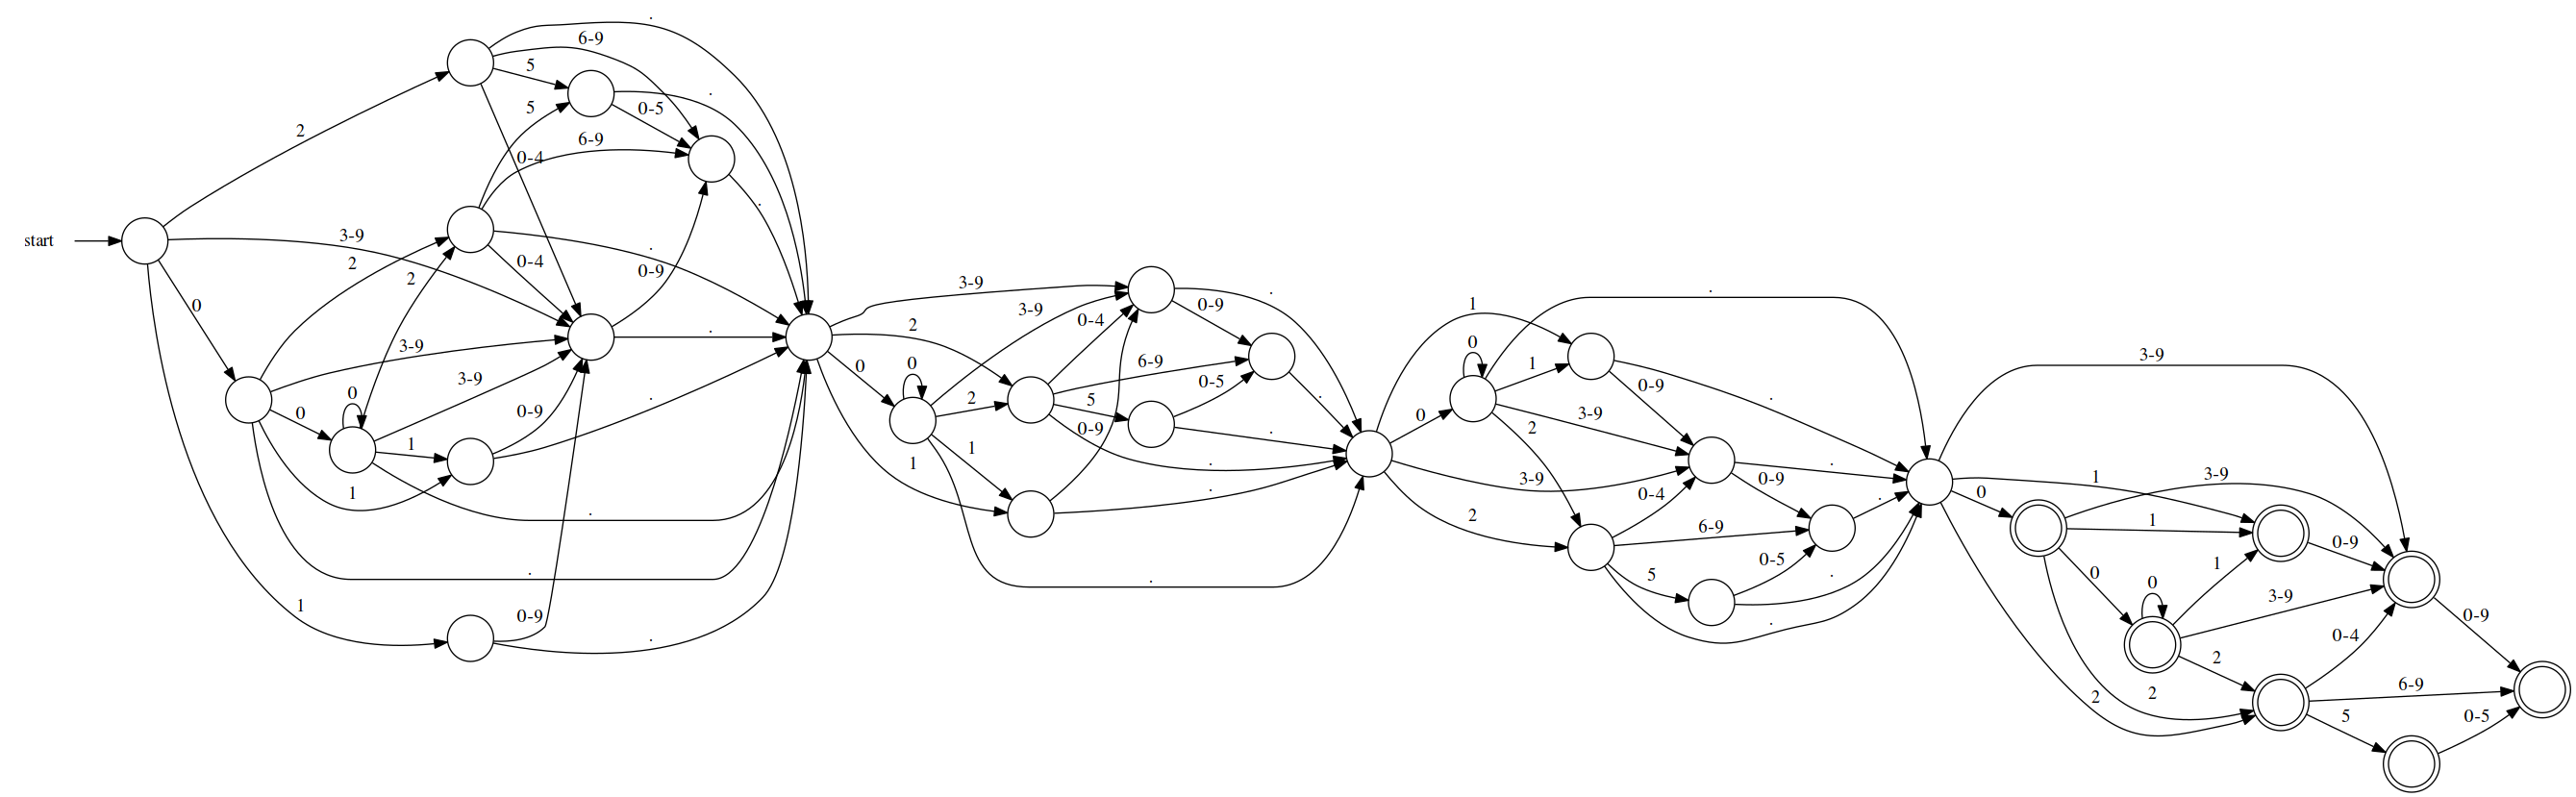

In [40]:
is_ip_d_min = dfa_min(nfa_to_dfa(is_ip.m))
FSM(is_ip_d_min.start, is_ip_d_min.accepts, is_ip_d_min.delta, label_states=False, trim_unreachable=True)

With a bit more work, you could use this as the basis of, say, an FPGA-based device to monitor a data stream for textual IP addresses. Associate output signals with the different states to transform this into a [Moore machine](https://en.wikipedia.org/wiki/Moore_machine), design a storage method triggered by those signals, and you could have a piece of hardware to parse IP addresses from otherwise unstructured data. If you were so inclined, of course.

## Regex Equality

Given two regular expressions, is it possible to determine whether they are actually equivalent, i.e., whether they match precisely the same set of input strings? The answer, it turns out, is yes. Our DFA minimization didn't just compute _a_ minimal DFA, it computed _the_ minimal DFA. Suppose I had written the original regular expression

```
/.*AAA.*|.*L.*L.*/
```

in the less factored form

```
/.*(AAA|L.*L).*/
```

Using the tools we already have, I could have constructed the NFA like so:

In [41]:
aaa = RE('A') * RE('A') * RE('A')
ll = RE('L') * ola().star() * RE('L')
loss = ola().star() * (aaa + ll) * ola().star()

Converting to DFA and minimizing would then give:

In [42]:
loss_d_min = dfa_min(nfa_to_dfa(loss.m))

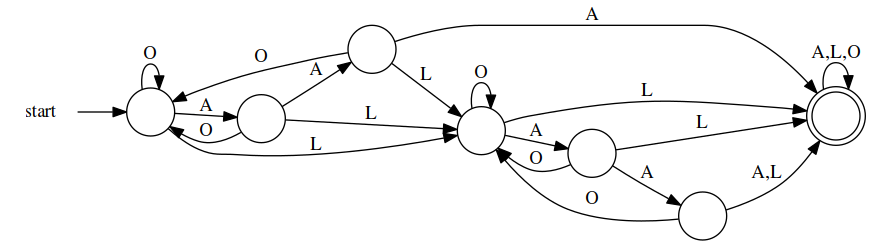

In [43]:
FSM(loss_d_min.start, loss_d_min.accepts, loss_d_min.delta, label_states=False)

Which looks damned familiar, yes? It turns out that we can use the idea of state distinguishability that we saw earlier to compare two different DFAs. All we have to do is adapt the `dist` from above to operate on input states from two different machines:

In [44]:
@guarded_memoize
def dist2(p, q, pm, qm):
    '''Determine whether two states p (from pm) and q (from qm) are distinguishable.'''
    
    # two states are distinguishable if one is accepting and the other isn't
    if (p in pm.accepts) != (q in qm.accepts): return True
    
    # or if there is a sequence of inputs that leads them to distinguishable
    # states
    try:
        sigma = set(pm.delta[p]) | set(qm.delta[q])
    except KeyError: return True
    return any(dist2(pm.delta[p].get(s),qm.delta[q].get(s), pm, qm) for s in sigma)


Then, we just need to use it to determine whether two machines' starting states are distinguishable:

In [45]:
def dfa_eq(m, n):
    return not dist2(m.start, n.start, m, n)

As an example, say we have a couple DFAs both recognizing `/123456789/`:

In [46]:
a = nfa_to_dfa((RE.from_string('123456') * RE('') * RE.from_string('789')).m)
b = nfa_to_dfa(RE.from_string('123456789').m)

And one recognizing `/(0123456789)*/`:

In [47]:
c = nfa_to_dfa(RE.from_alts('0123456789').star().m)

Using `dfa_eq` to perform a couple of comparisons gives the expected results:

In [48]:
print('''
a == b -> %s
b == c -> %s
'''
      % (dfa_eq(a, b), dfa_eq(b, c)))


a == b -> True
b == c -> False



## The Limits of Regular Expressions

We've made it quite a long way from the beginning, where we were stuck trying to break things out of text without a regular expression library. We can

1. Write Python based on regexes to construct NFAs that recognize interesting patterns;
1. Convert those NFAs to DFAs and minimize them; and,
1. Test DFAs for equivalence.

And then there's the possibility of transforming minimal DFAs to circuitry. If we wanted, we could write a back-end using [MyHDL](http://www.myhdl.org/) to generate synthesizable Verilog and a front end to parse regular expressions, thereby automating much of the path from regular expression to silicon. Before going down that road, however, let's talk about parsing regular expressions. In particular, let's talk about why we can't do that just yet.

Consider that regular expressions consist of literal characters and metacharacters, i.e., characters with special significance to the regex engine. If we limit the entire set of metacharacters to the class `[|*+\]`, we could describe regular expressions using the regular expression facilities we have so far:

In [49]:
metas = set('|+*\\')
literals = {chr(i) for i in range(256)} - metas

literal = lambda: RE.from_alts(list(literals))
meta = lambda: RE.from_alts(list(metas))
escaped = lambda: RE('\\') * (literal() + meta())
char = lambda: literal() + escaped()
star = lambda: char() * RE('*')
plus = lambda: char() * RE('+')
basic_sequence = lambda: (char() + star() + plus()).star()

regex = basic_sequence() * (RE('|') * basic_sequence()).star()

With this, we can recognize valid regexes (in our limited syntax) when we see them, and recognition is the first step to parsing. There's something missing, though&mdash;parentheses. Without the ability to delimit subexpressions, we're extremely limited in what we can write. For example, something as simple as `/(ab)*/` would be out of the question, let alone describing a C comment, a floating point number, or even an IP address. So, how do we work them in? More fundamentally, if regular expressions are the most powerful tool we have, can use them to recognize valid regular expressions?

In the theory of computation, we have the [pumping lemma](https://en.wikipedia.org/wiki/Pumping_lemma_for_regular_languages) for regular languages (i.e., the set of all languages that can be described by regular expressions) which describes a property that all regular languages have. This lemma states that if a string of sufficient length matches a regular expression, then it will have caused the equivalent minimal DFA to visit at least one state more than once. If we can identify the substring that caused the DFA to move in a cycle of states, we can insert an arbitrary number of repetitions of that substring to give a new string that will also match the regex.

Now, let's imagine that there exists a regex, and thus a DFA, that can describe a language that consists only of balanced parentheses; we'd need that capability to add parenthesization to our regex language, and considering other characters will clutter the discussion. We don't yet know how long a string we need to make the DFA revisit a state, but we'll call it _p_. Now, let's say we have a string of _p_ open parentheses followed by _p_ closed parentheses; this string is obviously a member of the balanced-paren language. 

The pumping lemma states that, since the length of the string is at least _p_, there must be at least one state that was revisited; we also know that, since the revisitation happened by the _p_<sup>th</sup> character, the substring that caused the cycle had to have occurred in the first half, i.e., it consisted only of open parentheses. According to the pumping lemma, we're able to insert an arbitrary number of repetitions of that substring and still end up with a string matching the regex describing balanced parentheses; however, we know that inserting additional open parentheses into a balanced-paren string will lead to an imbalance, and therefore the result can't match the regex. Since our assumption that such a regex exists leads to a contradiction, we can only conclude that strings with balanced parentheses cannot be comprehensively described using regular expressions. Furthermore, since a complete regular expression syntax requires balanced parentheses in addition to the literals and other metacharacters, we also know that we cannot use regular expressions to describe regular expressions.

A different way to think about this is that matching parentheses requires our recognition device to remember how many unmatched open parentheses there are. Since the only way for a DFA to remember anything is to be in one of a set of states corresponding to it, and since the unmatched open parentheses could easily outnumber the available states, we can see that the fundamental limitation of a DFA is that it can store only a finite amount of information (remember the 'F' in DFA?). This limitation applies to any string matching task that involves recursive structures or algebraic relationships between substrings. It is why "HTML and regex go together like love, marriage, and ritual infanticide."

We need two things to break out of this rut:

* A memory structure that can accomodate an arbirary amount of information; and,
* A notation that allows us to represent arbitrarily nested expressions.

What we need is to crawl up the [Chomsky hierarchy](https://en.wikipedia.org/wiki/Chomsky_hierarchy) to a more powerful language representation and corresponding computational model. But not in this post. It's really gotten quite long.